# 음성 합성(Speech Synthesis)

* https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/Tacotron2

## Tacotron 2

* 텍스트에서 멜 스펙트로그램 생성

* https://pytorch.org/hub/nvidia_deeplearningexamples_tacotron2/

<img src="https://pytorch.org/assets/images/tacotron2_diagram.png" alt="alt" width="50%"/>

## WaveGlow

* 멜 스펙트로그램에서 음성 생성

* https://pytorch.org/hub/nvidia_deeplearningexamples_waveglow/

<img src="https://pytorch.org/assets/images/waveglow_diagram.png" alt="alt" width="50%"/>

In [ ]:
!pip install numpy scipy librosa unidecode inflect

* LJ Speech dataset에서 사전 학습된 Tacotron2와 WaveGlow 모델 로드

In [ ]:
import torch

tacotron2 = torch.hub.load('nvidia/DeepLearningExamples:torchhub','nvidia_tacotron2')
waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub','nvidia_waveglow')

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/nvidia/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

In [ ]:
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0-2): 3 x Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (linear_layer): Linear(in_features=80, out_features=256, bias=False)
        )
        (1): LinearNorm(
          (linear_layer): Linear(in_features=256, out_features=256, bias=False)
        )
      )
    )
    (attention_rnn): LSTMCell(768, 1024)
    (attention_layer): Attention(
      (query_layer): LinearNorm(
        (linear_layer): Linear(in_features=1024, out_features=128, bias=False)
      )
      (memory_layer): LinearNorm(
        (linear_layer): Linear(in_fea

In [ ]:
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0-3): 4 x WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0-6): 7 x Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (7

## Text To Speech(TTS)

In [ ]:
!pip install torchaudio librosa
# CUDA를 지원하는 버전 설치
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import re
import torch
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Load Tacotron2 and WaveGlow models from PyTorch Hub
tacotron2 = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_tacotron2').to('cuda')
waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_waveglow').to('cuda')

# Set the models to evaluation mode
tacotron2.eval()
waveglow.eval()

# Custom text preprocessing function
def custom_text_to_sequence(text):
    # Only keep alphabet and spaces, and lowercase the text
    text = re.sub(r'[^A-Za-z0-9\s]', '', text).lower()
    symbol_to_id = {s: i for i, s in enumerate("abcdefghijklmnopqrstuvwxyz' ")}

    sequence = [symbol_to_id.get(s, 0) for s in text]
    return torch.IntTensor(sequence).unsqueeze(0)

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower',
                       interpolation='none', cmap='viridis')

def TTS(text):
    # Preprocess the text
    sequence = custom_text_to_sequence(text).to('cuda')
    input_lengths = torch.IntTensor([sequence.size(1)]).to('cuda')  # 추가된 코드

    # Generate Mel spectrogram using Tacotron2
    with torch.no_grad():
        _, mel_outputs_postnet, _ = tacotron2.infer(sequence, input_lengths)  # input_lengths 추가

        # Generate audio using WaveGlow
        audio = waveglow.infer(mel_outputs_postnet)

    mel_output_postnet = mel_outputs_postnet.data.cpu().numpy()[0]
    audio_np = audio[0].data.cpu().numpy()

    return mel_output_postnet, audio_np, 22050

# Run TTS and plot results
text = 'Hello, how are you?'
mel_output_postnet, audio_np, sampling_rate = TTS(text)

# Plot wave and mel spectrogram
fig = plt.figure(figsize=(14, 4))
librosa.display.waveshow(audio_np, sr=sampling_rate)
plot_data([mel_output_postnet])
plt.show()

# Play audio
ipd.Audio(audio_np, rate=sampling_rate)


Using cache found in /root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub


RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv_transpose1d, but got input of size: [1]

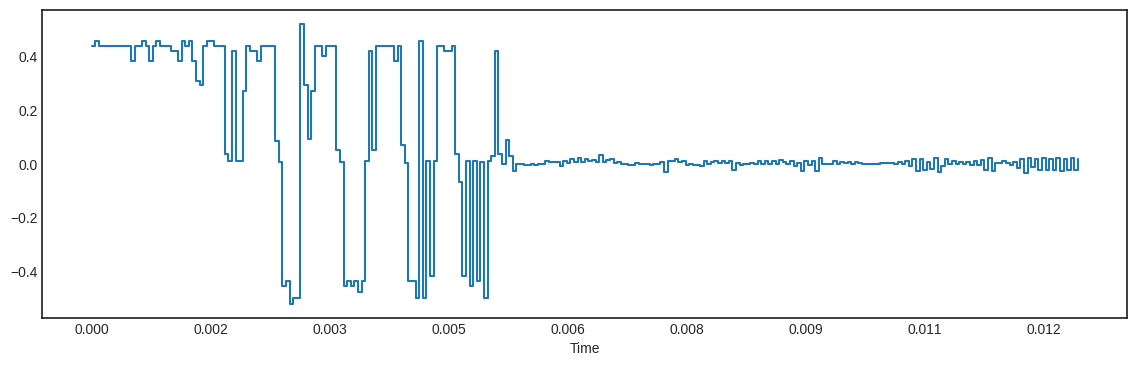

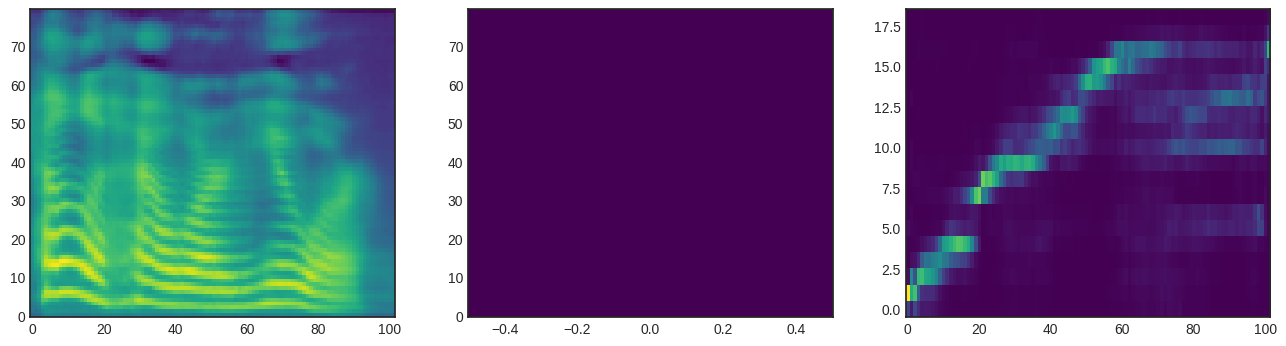

Audio shape: (1, 275)
Audio sample (first 10 values): [[ 4.35443223e-01  4.54973400e-01  4.35443223e-01  4.35443223e-01
   4.35443223e-01  4.35443223e-01  4.35443223e-01  4.35443223e-01
   4.35443223e-01  4.35443223e-01  4.35443223e-01  3.81699413e-01
   4.35443223e-01  4.35443223e-01  4.54973400e-01  4.35443223e-01
   3.81699413e-01  4.35443223e-01  4.54973400e-01  4.35443223e-01
   4.35443223e-01  4.35443223e-01  4.16744024e-01  4.16744024e-01
   3.81699413e-01  4.54973400e-01  4.35443223e-01  4.54973400e-01
   3.81699413e-01  3.06334257e-01  2.93129891e-01  4.35443223e-01
   4.54973400e-01  4.54973400e-01  4.35443223e-01  4.35443223e-01
   4.35443223e-01  3.45454141e-02  7.96640757e-03  4.16744024e-01
   8.49484187e-03  7.96640757e-03  2.68383265e-01  4.35443223e-01
   4.16744024e-01  4.16744024e-01  3.81699413e-01  4.35443223e-01
   4.35443223e-01  4.35443223e-01  4.35443223e-01  8.39732811e-02
   6.06819848e-03 -4.54973191e-01 -4.35442805e-01 -5.18928885e-01
  -4.96676803e-01 -4.9

In [ ]:
import librosa.display
from IPython.display import Audio
text = 'Hello, how are you?'
mel_output, mel_output_postnet, alignment, audio_np, sampling_rate = TTS(text)

# 오디오 파형과 Mel Spectrogram, alignment 시각화
fig = plt.figure(figsize=(14, 4))
librosa.display.waveshow(audio_np, sr=sampling_rate)
plot_data((mel_output, mel_output_postnet, alignment))
plt.show()
Audio(audio_np,rate=sampling_rate)


print("Audio shape:", audio_np.shape)
print("Audio sample (first 10 values):", audio_np[:10])